## Importing Major Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import welch, find_peaks
import warnings as wr
wr.filterwarnings('ignore')

## Importing the Dataset

In [39]:
# Importing the CSV file
df = pd.read_csv('B1_CL4_20.csv',low_memory=False)

## Creating windows, then calculating Mean and RMS for each window-Root Moments

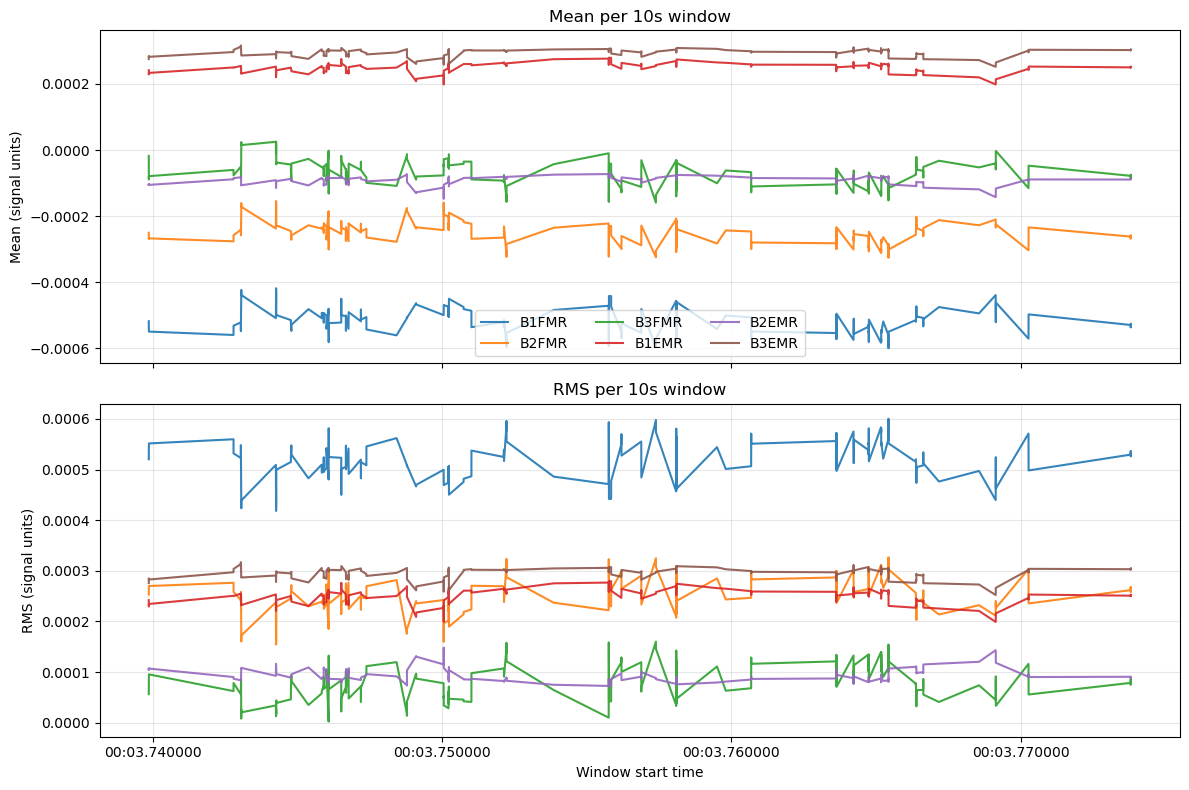

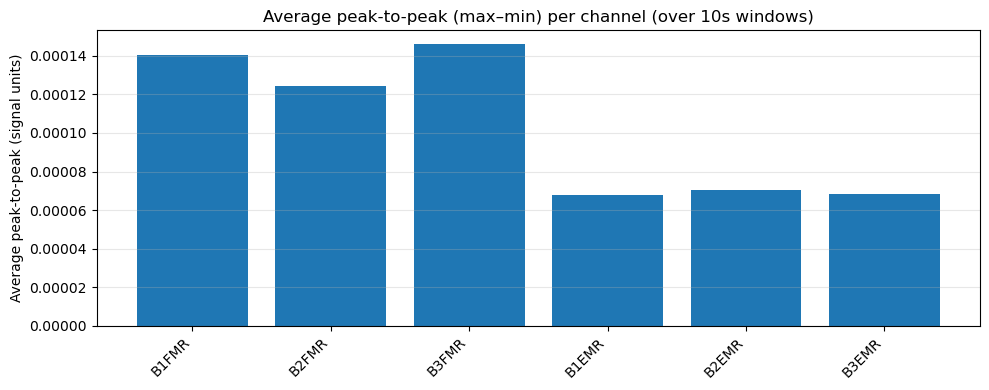

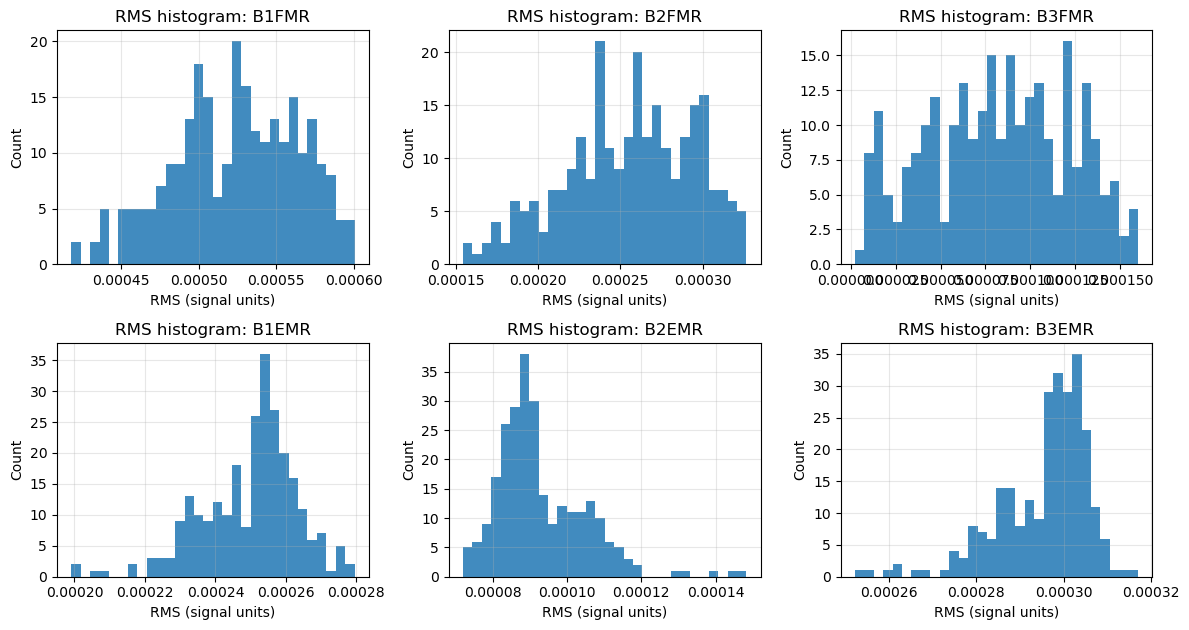

In [41]:
# CONFIG
fs = 2000                 # sampling frequency [Hz]
window_sec = 10          # window length [s]
cols = ['B1FMR','B2FMR','B3FMR','B1EMR','B2EMR','B3EMR']  # edit as needed
time_col = 'Time'        # set to None if you don't have timestamps


# STATS PER WINDOW

def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(df, cols, fs, window_sec, time_col=time_col)

# Helper: choose the x-axis (time if available, else window index)
if time_col and f'window_start_time' in stats.columns:
    x = pd.to_datetime(stats['window_start_time'], errors='coerce')
    x_label = 'Window start time'
else:
    x = stats['window']
    x_label = 'Window #'


# LINE PLOTS: MEAN & RMS OVER TIME

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


# BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)

avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


# HISTOGRAMS: RMS DISTRIBUTIONS

n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Creating windows, then calculating Mean and RMS for each window-Flapwise Moments(2m, 3.5m, 5m)

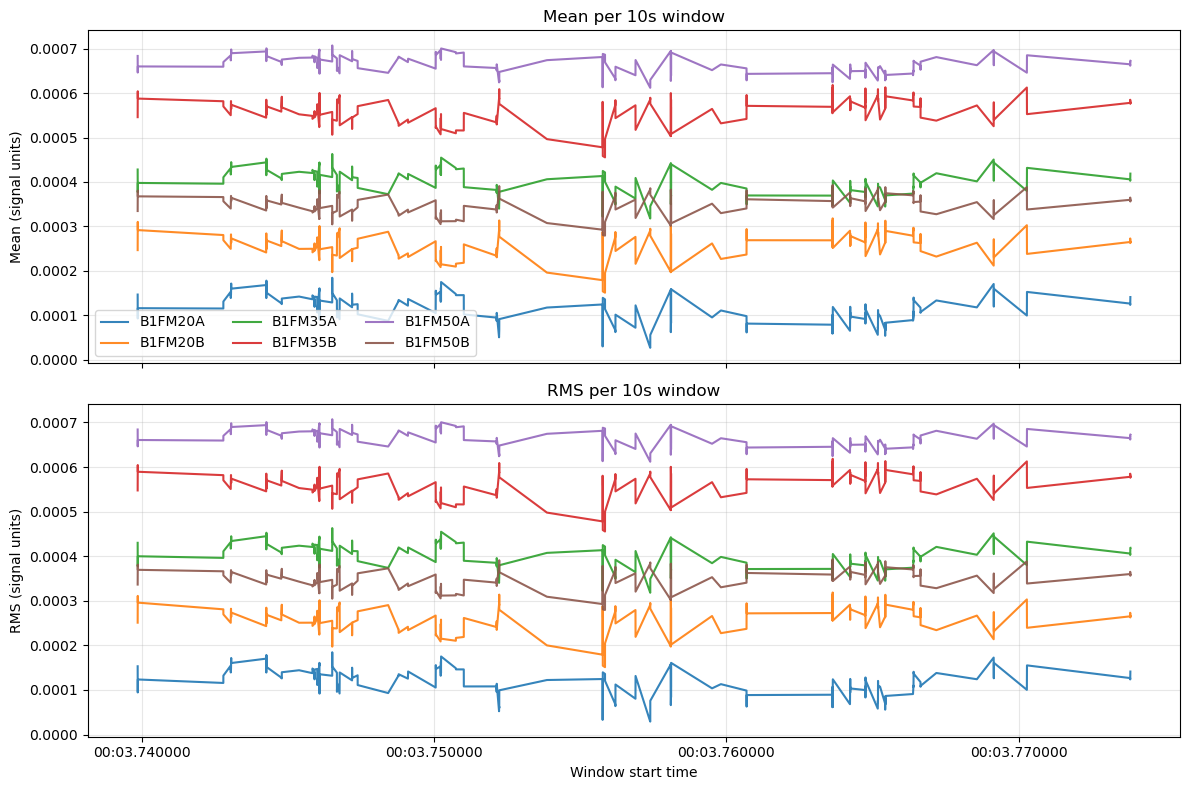

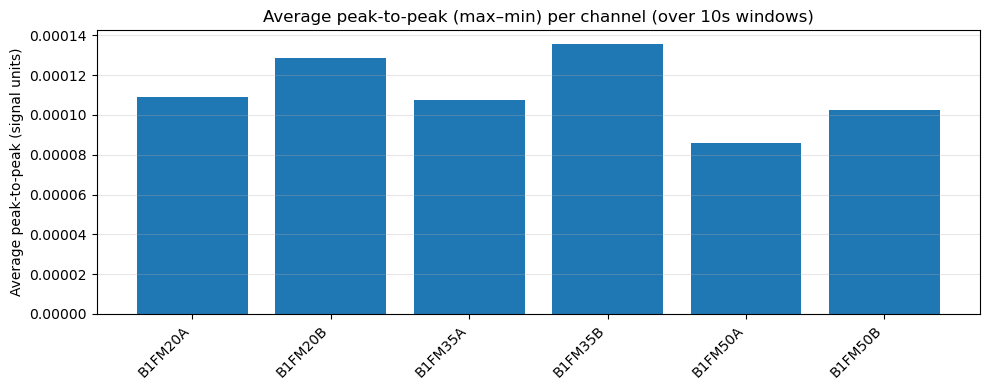

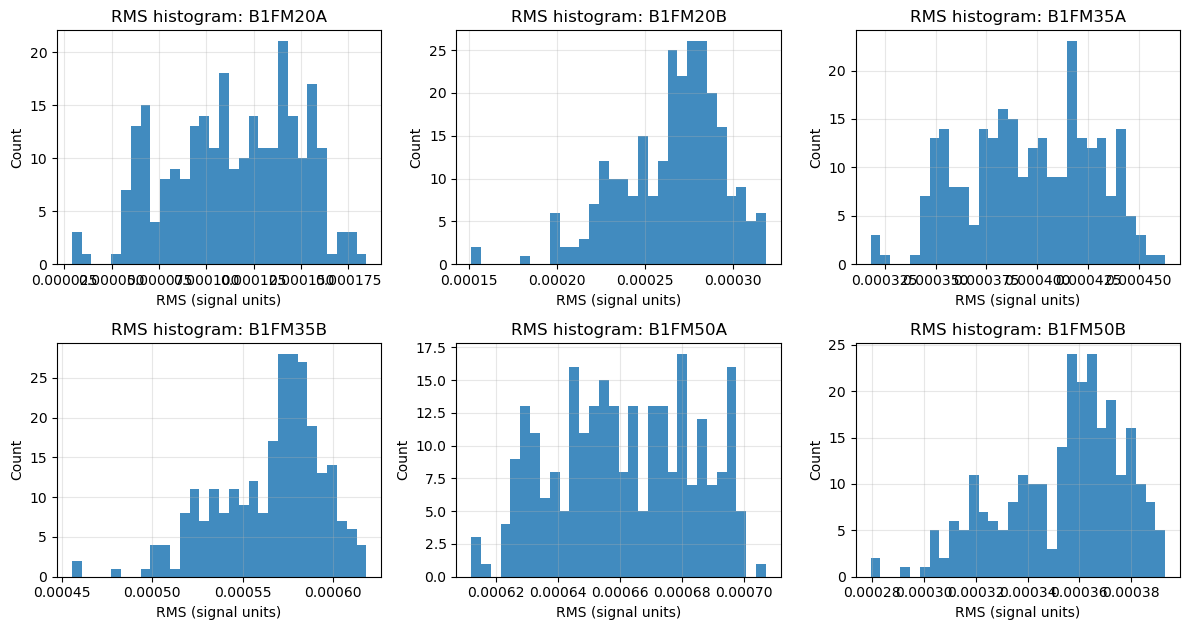

In [43]:
# CONFIG
fs = 2000                 # sampling frequency [Hz]
window_sec = 10          # window length [s]
cols = ['B1FM20A', 'B1FM20B', 'B1FM35A', 'B1FM35B', 'B1FM50A','B1FM50B']  # edit as needed
time_col = 'Time'        # set to None if you don't have timestamps


# STATS PER WINDOW
def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(df, cols, fs, window_sec, time_col=time_col)

# Helper: choose the x-axis (time if available, else window index)
if time_col and f'window_start_time' in stats.columns:
    x = pd.to_datetime(stats['window_start_time'], errors='coerce')
    x_label = 'Window start time'
else:
    x = stats['window']
    x_label = 'Window #'


# LINE PLOTS: MEAN & RMS OVER TIME

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


# BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)

avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


# HISTOGRAMS: RMS DISTRIBUTIONS

n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Creating windows, then calculating Mean and RMS for each window-Tower Moments

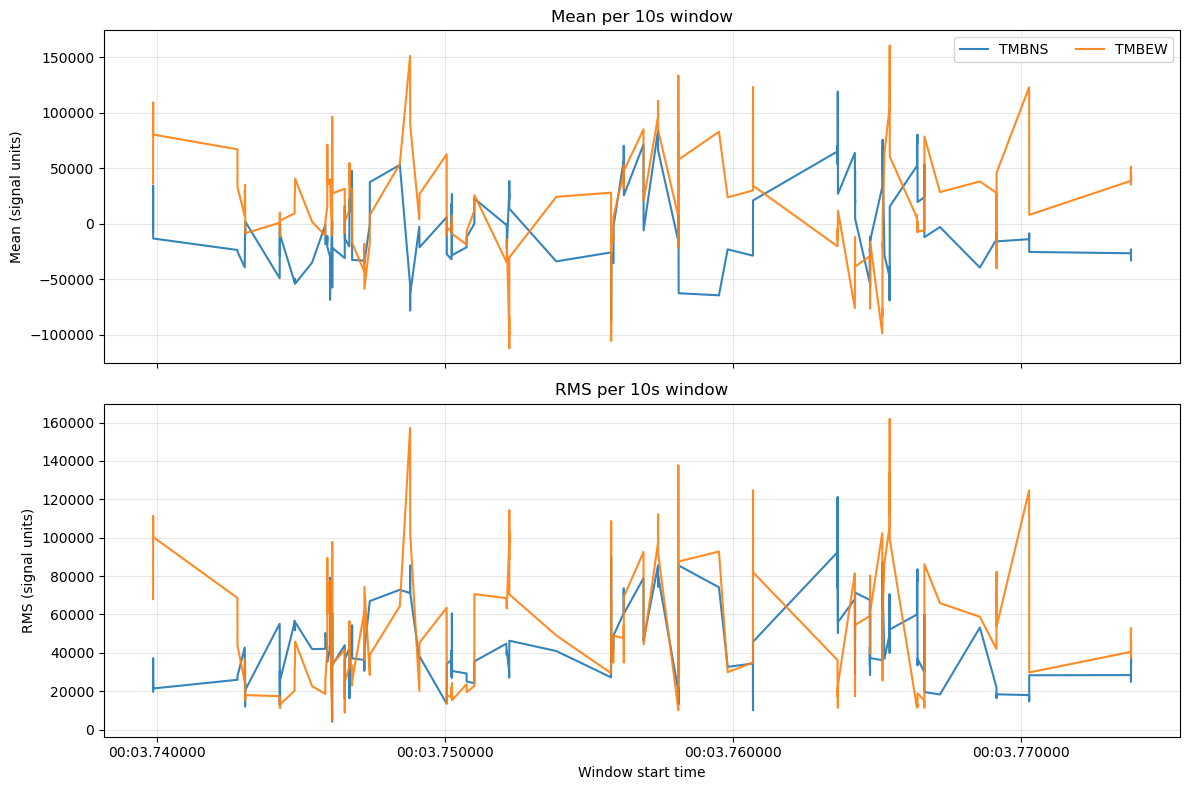

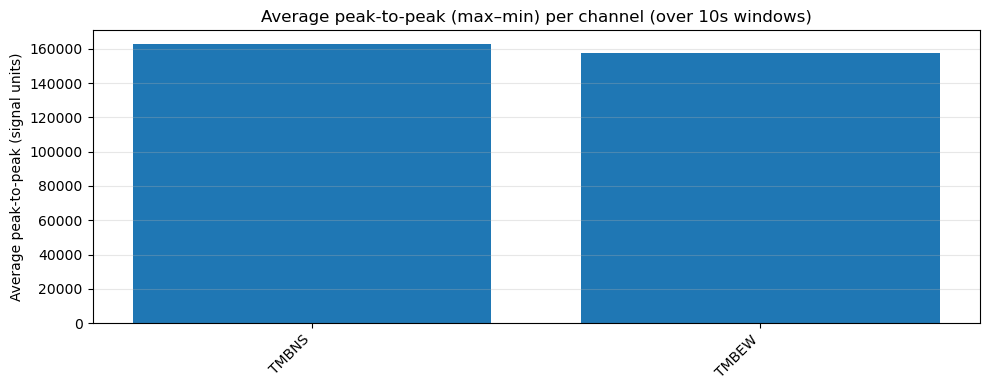

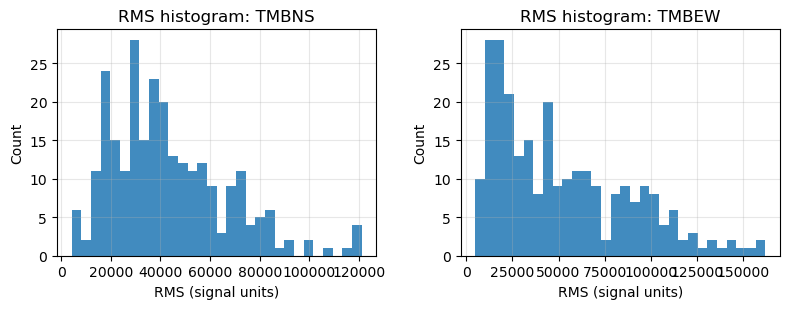

In [45]:
# CONFIG

fs = 2000                 # sampling frequency [Hz]
window_sec = 10          # window length [s]
cols = ['TMBNS', 'TMBEW']  # edit as needed
time_col = 'Time'        # set to None if you don't have timestamps


# STATS PER WINDOW

def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(df, cols, fs, window_sec, time_col=time_col)

# Helper: choose the x-axis (time if available, else window index)
if time_col and f'window_start_time' in stats.columns:
    x = pd.to_datetime(stats['window_start_time'], errors='coerce')
    x_label = 'Window start time'
else:
    x = stats['window']
    x_label = 'Window #'


# 1) LINE PLOTS: MEAN & RMS OVER TIME

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


# 2) BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)

avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


# 3) HISTOGRAMS: RMS DISTRIBUTIONS

n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Creating windows, then calculating Mean and RMS for each window- Wind Speed

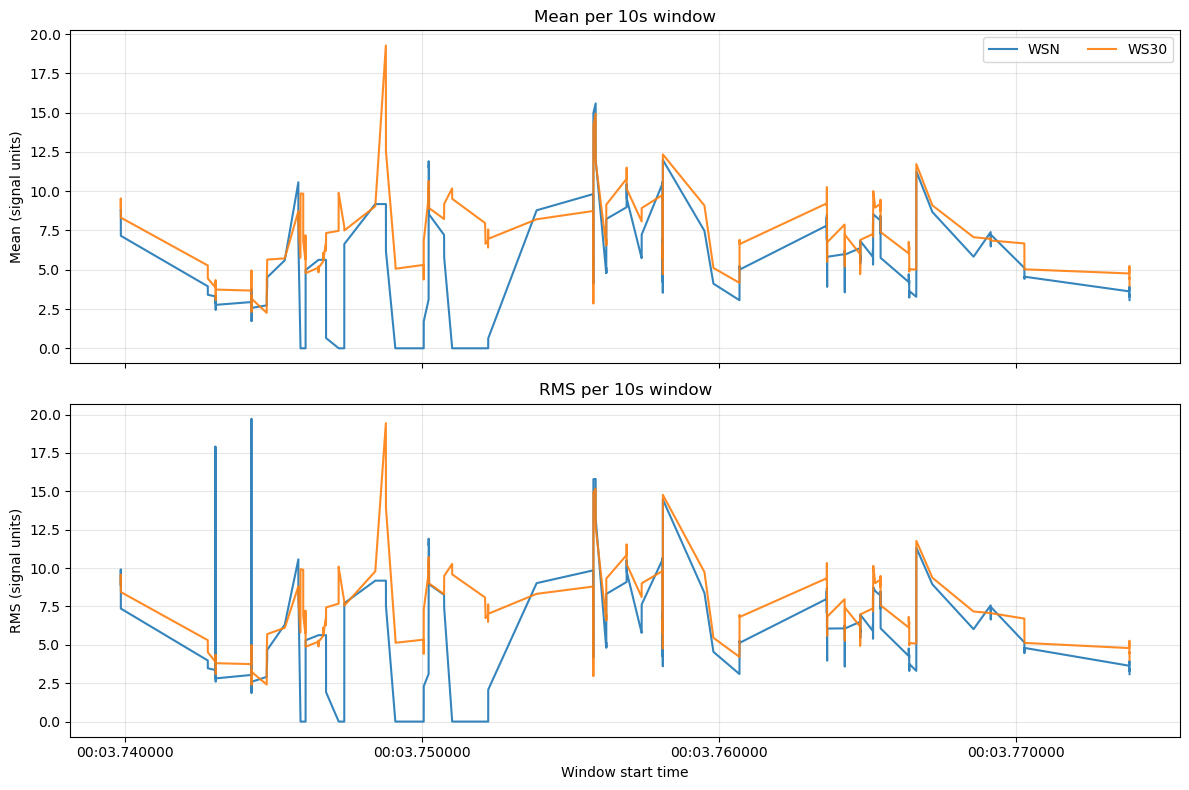

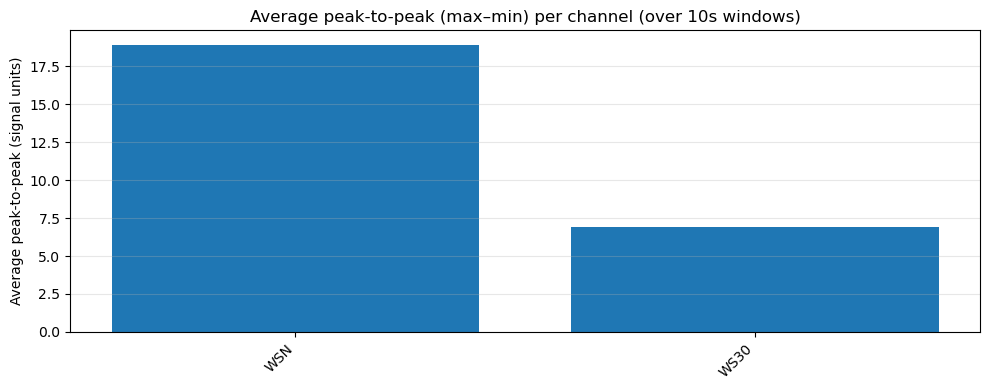

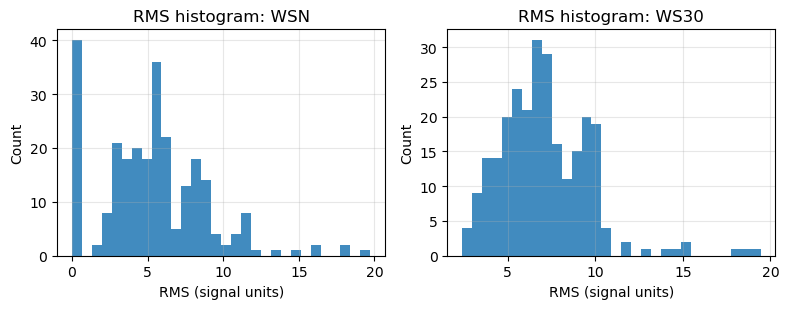

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# CONFIG
# -----------------------
fs = 2000                 # sampling frequency [Hz]
window_sec = 10          # window length [s]
cols = ['WSN', 'WS30']  # edit as needed
time_col = 'Time'        # set to None if you don't have timestamps

# -----------------------
# STATS PER WINDOW
# -----------------------
def compute_window_stats(df, cols, fs, window_sec, time_col=None):
    win = int(window_sec * fs)
    n = len(df)
    windows = [(i, i+win) for i in range(0, n - win + 1, win)]  # non-overlapping

    rows = []
    for w_idx, (i0, i1) in enumerate(windows, start=1):
        w = df.iloc[i0:i1]
        row = {'window': w_idx,
               'window_start_idx': i0,
               'window_end_idx': i1-1}
        if time_col and time_col in df.columns:
            row['window_start_time'] = w[time_col].iloc[0]
            row['window_end_time']   = w[time_col].iloc[-1]
        for c in cols:
            x = w[c].to_numpy(dtype=float)
            row[f'{c}_mean'] = np.nanmean(x)
            row[f'{c}_rms']  = float(np.sqrt(np.nanmean(x**2)))
            row[f'{c}_std']  = np.nanstd(x)
            row[f'{c}_min']  = np.nanmin(x)
            row[f'{c}_max']  = np.nanmax(x)
        rows.append(row)
    return pd.DataFrame(rows)

stats = compute_window_stats(df, cols, fs, window_sec, time_col=time_col)

# Helper: choose the x-axis (time if available, else window index)
if time_col and f'window_start_time' in stats.columns:
    x = pd.to_datetime(stats['window_start_time'], errors='coerce')
    x_label = 'Window start time'
else:
    x = stats['window']
    x_label = 'Window #'

# -----------------------
# 1) LINE PLOTS: MEAN & RMS OVER TIME
# -----------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
for c in cols:
    axes[0].plot(x, stats[f'{c}_mean'], label=c, alpha=0.9)
axes[0].set_title(f'Mean per {window_sec}s window')
axes[0].set_ylabel('Mean (signal units)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(ncol=min(3, len(cols)))

for c in cols:
    axes[1].plot(x, stats[f'{c}_rms'], label=c, alpha=0.9)
axes[1].set_title(f'RMS per {window_sec}s window')
axes[1].set_xlabel(x_label)
axes[1].set_ylabel('RMS (signal units)')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()

# -----------------------
# 2) BAR CHART: AVERAGE PEAK-TO-PEAK RANGE (max - min)
# -----------------------
avg_range = {}
for c in cols:
    p2p = stats[f'{c}_max'] - stats[f'{c}_min']
    avg_range[c] = float(np.nanmean(p2p))

plt.figure(figsize=(10,4))
plt.bar(list(avg_range.keys()), list(avg_range.values()))
plt.title(f'Average peak-to-peak (max–min) per channel (over {window_sec}s windows)')
plt.ylabel('Average peak-to-peak (signal units)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# -----------------------
# 3) HISTOGRAMS: RMS DISTRIBUTIONS
# -----------------------
n_cols = min(3, len(cols))
n_rows = int(np.ceil(len(cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.2*n_rows))
axes = np.atleast_1d(axes).ravel()

for ax, c in zip(axes, cols):
    ax.hist(stats[f'{c}_rms'].dropna(), bins=30, alpha=0.85)
    ax.set_title(f'RMS histogram: {c}')
    ax.set_xlabel('RMS (signal units)')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

for ax in axes[len(cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


## Event Detection (Gust) - Derivative Method

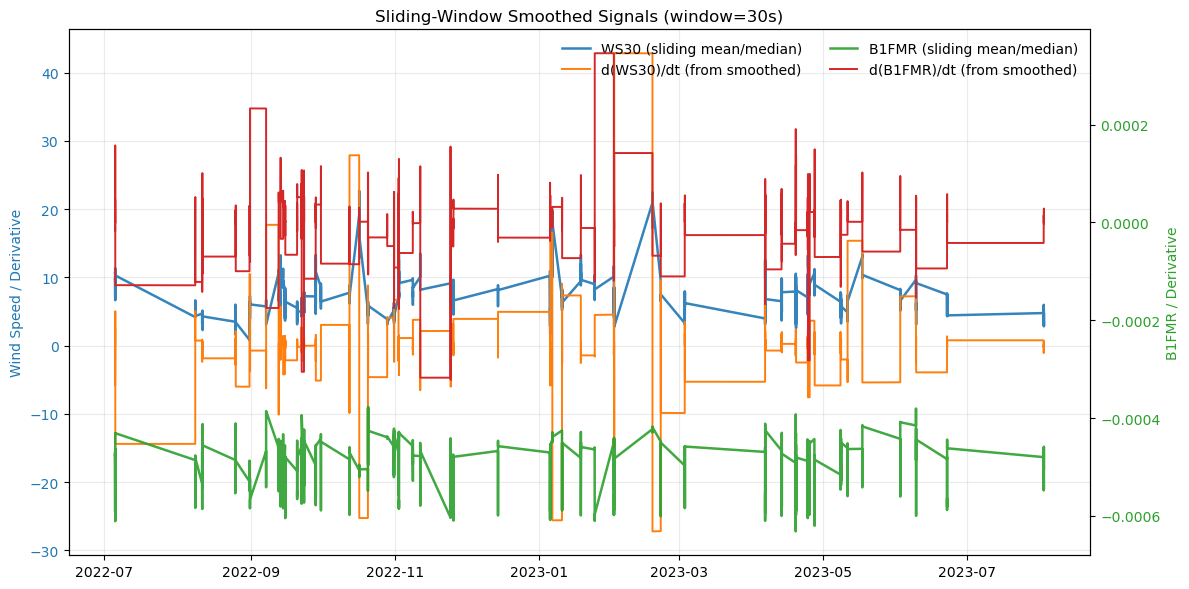

In [51]:

# ---------------- CONFIG ----------------
TIME_COL = "Time"
WIND_COL = "WS30"
YAW_COL  = "YS"
LOAD_COL = "B1FMR"

WIN_SEC  = 30          # sliding-window length in seconds (try 5–30)
USE_MEDIAN = True      # robust smoothing (median) or mean
SG_SMOOTH = True       # extra light Savitzky-Golay polish on derivatives

# Vibrant, colorblind-friendly colors
C_WS  = "#1f77b4"  # blue
C_DWS = "#ff7f0e"  # orange
C_FMR = "#2ca02c"  # green
C_DFMR= "#d62728"  # red

# ---------------- PREP ----------------
# Convert Time (seconds since 1904) to datetime and sort
epoch_1904 = pd.Timestamp("1904-01-01 00:00:00Z")
t = epoch_1904 + pd.to_timedelta(df[TIME_COL].astype(float), unit="s")
t = t.dt.tz_localize(None)
d = df.copy()
d.index = t
d = d.sort_index()

# Estimate sampling period and create a time-based rolling window
if len(d) < 3:
    raise ValueError("Not enough samples to compute a rolling window.")
dt_est = np.median(np.diff(d.index.view("int64"))) / 1e9          # seconds
fs_est = 1.0 / dt_est if dt_est > 0 else 1.0
win = f"{WIN_SEC}s"                                               # time-based window string

# ---------------- SMOOTHING ----------------
def roll(series):
    if USE_MEDIAN:
        return series.rolling(win, center=True, min_periods=max(3, int(WIN_SEC*fs_est*0.3))).median()
    else:
        return series.rolling(win, center=True, min_periods=max(3, int(WIN_SEC*fs_est*0.3))).mean()

ws_s   = roll(d[WIND_COL].astype(float))
yaw_s  = roll(d[YAW_COL].astype(float))
fmr_s  = roll(d[LOAD_COL].astype(float))

# ---------------- DERIVATIVES on SMOOTHED SIGNALS ----------------
# finite-difference derivative using estimated dt
def deriv(series, dt):
    x = series.values
    # handle NaNs by forward/backward fill before gradient
    x = pd.Series(x, index=series.index).interpolate("time").bfill().ffill().values
    return pd.Series(np.gradient(x, dt), index=series.index)

dws_dt  = deriv(ws_s, dt_est)
dfmr_dt = deriv(fmr_s, dt_est)

# optional gentle smoothing on derivatives for nicer visuals
if SG_SMOOTH:
    # choose odd window ~ 1–2 s
    wlen = int(max(5, (1.0/dt_est))) | 1  # ensure odd
    dws_dt  = pd.Series(savgol_filter(dws_dt.values, wlen, 2), index=dws_dt.index)
    dfmr_dt = pd.Series(savgol_filter(dfmr_dt.values, wlen, 2), index=dfmr_dt.index)

# ---------------- PLOT ----------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Wind speed & derivative (left axis)
ax1.plot(d.index, ws_s,  color=C_WS,  lw=1.8, alpha=0.9, label="WS30 (sliding mean/median)")
ax1.plot(d.index, dws_dt, color=C_DWS, lw=1.4, label="d(WS30)/dt (from smoothed)")
ax1.set_ylabel("Wind Speed / Derivative", color=C_WS)
ax1.tick_params(axis='y', labelcolor=C_WS)
ax1.grid(alpha=0.25)

# Blade load & derivative (right axis)
ax2 = ax1.twinx()
ax2.plot(d.index, fmr_s,   color=C_FMR, lw=1.8, alpha=0.9, label="B1FMR (sliding mean/median)")
ax2.plot(d.index, dfmr_dt, color=C_DFMR, lw=1.4, label="d(B1FMR)/dt (from smoothed)")
ax2.set_ylabel("B1FMR / Derivative", color=C_FMR)
ax2.tick_params(axis='y', labelcolor=C_FMR)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", ncol=2, frameon=False)

plt.title(f"Sliding-Window Smoothed Signals (window={WIN_SEC}s)")
plt.xlabel("Time")
plt.tight_layout()
plt.show()
